In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from torch.utils.data import ConcatDataset, DataLoader
class CaptchaDetectionDataset(Dataset):
    def __init__(self, field_folder, draw_folder, label_csv, 
                 transform_field=None, transform_draw=None, transform_label=None):
        """
        Args:
            field_folder (str): Path to the folder containing field images (210x210).
            draw_folder (str): Path to the folder containing draw images (50x50).
            label_csv (str): Path to the CSV file containing labels with columns:
                             "img_name", "x", "y".
            transform_field (callable, optional): Transform to apply to field images.
            transform_draw (callable, optional): Transform to apply to draw images.
            transform_label (callable, optional): Transform to apply to labels.
        """
        self.field_folder = field_folder
        self.draw_folder = draw_folder
        self.labels_df = pd.read_csv(label_csv)
        
        # Optional transforms for images/labels
        self.transform_field = transform_field
        self.transform_draw = transform_draw
        self.transform_label = transform_label
        
        # Create a list of image names from the CSV
        self.img_names = self.labels_df["img_name"].tolist()
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        # Get the image file name from CSV
        img_name = self.img_names[idx]
        
        # Construct full paths for field and draw images
        field_img_path = os.path.join(self.field_folder, img_name)
        draw_img_path = os.path.join(self.draw_folder, img_name)
        
        # Load images using PIL and convert them to RGB
        field_img = Image.open(field_img_path).convert('RGB')
        draw_img = Image.open(draw_img_path).convert('RGB')
        
        # Apply transformations if provided (for example, resizing, normalization, converting to tensor)
        if self.transform_field:
            field_img = self.transform_field(field_img)
        if self.transform_draw:
            draw_img = self.transform_draw(draw_img)
        
        # Extract label (x, y) from the CSV row and convert to a float tensor
        row = self.labels_df.iloc[idx]
        x = float(row["x"])
        y = float(row["y"])
        label = torch.tensor([x, y], dtype=torch.float32)
        if self.transform_label:
            label = self.transform_label(label)
        
        return field_img, draw_img, label

# Example usage:
def create_train_dataset():
    # Define transforms: Convert images to tensors, resize if needed, etc.
    transform_field = transforms.Compose([
        transforms.Resize((210, 210)),
        transforms.ToTensor()  # Converts to tensor and scales pixel values to [0, 1]
    ])
    
    transform_draw = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor()
    ])

    train_folder = "train_set/"
    # Folder paths
    field_folder = train_folder + "field"   # e.g., images of size 210x210
    draw_folder = train_folder + "rotated_draw1"       # e.g., images of size 50x50
    label_csv = train_folder + "rotated_draw1/augmented_labels.csv"          # CSV with columns: "img_name", "x", "y"
    
    # Create dataset
    dataset1 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)

    field_folder = train_folder + "field"    # e.g., images of size 210x210
    draw_folder = train_folder + "rotated_draw2"       # e.g., images of size 50x50
    label_csv = train_folder + "rotated_draw2/augmented_labels.csv"           # CSV with columns: "img_name", "x", "y"

    # Create dataset
    dataset2 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)


    dataset = ConcatDataset([dataset1, dataset2])
    return dataset

def create_test_dataset():
    # Define transforms: Convert images to tensors, resize if needed, etc.
    transform_field = transforms.Compose([
        transforms.Resize((210, 210)),
        transforms.ToTensor()  # Converts to tensor and scales pixel values to [0, 1]
    ])
    
    transform_draw = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor()
    ])

    test_folder = "test_set/"
    # Folder paths
    field_folder = test_folder + "field"   # e.g., images of size 210x210
    draw_folder = test_folder + "rotated_draw1"       # e.g., images of size 50x50
    label_csv = test_folder + "rotated_draw1/augmented_labels.csv"          # CSV with columns: "img_name", "x", "y"
    
    # Create dataset
    dataset1 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)

    field_folder = test_folder + "field"    # e.g., images of size 210x210
    draw_folder = test_folder + "rotated_draw2"       # e.g., images of size 50x50
    label_csv = test_folder + "rotated_draw2/augmented_labels.csv"           # CSV with columns: "img_name", "x", "y"

    # Create dataset
    dataset2 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)


    dataset = ConcatDataset([dataset1, dataset2])
    return dataset


dataset = create_test_dataset()
# dataset = create_train_dataset()
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate over one batch and print shapes
for field_img, draw_img, label in data_loader:
    print("Field image batch shape:", field_img.shape)  # Expected: (B, 3, 210, 210)
    print("Draw image batch shape:", draw_img.shape)    # Expected: (B, 3, 50, 50)
    print("Label batch shape:", label.shape)            # Expected: (B, 2)
    break


Field image batch shape: torch.Size([8, 3, 210, 210])
Draw image batch shape: torch.Size([8, 3, 50, 50])
Label batch shape: torch.Size([8, 2])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DrawLocatorNet(nn.Module):
    def __init__(self):
        super(DrawLocatorNet, self).__init__()
        # Field branch: for the field image (210x210)
        # We use three convolutional blocks.
        self.field_cnn = nn.Sequential(
            # Block 1: 210x210 -> 105x105
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B,32,210,210)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # (B,32,105,105)
            
            # Block 2: 105x105 -> 52x52 (approx.)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B,64,105,105)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # (B,64,52,52)
            
            # Block 3: 52x52 -> 26x26
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# (B,128,52,52)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)                            # (B,128,26,26)
        )
        
        # Draw branch: for the draw image (50x50)
        # We use three convolutional blocks and an adaptive average pooling to get a feature vector.
        self.draw_cnn = nn.Sequential(
            # Block 1: 50x50 -> 25x25
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # (B,32,50,50)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B,32,25,25)
            
            # Block 2: 25x25 -> 12x12 (approx.)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (B,64,25,25)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B,64,12,12)
            
            # Block 3: 12x12 remains 12x12 but increases channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B,128,12,12)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                    # (B,128,1,1)
        )
    
    def forward(self, field_img, draw_img):
        """
        Args:
            field_img: Tensor of shape (B,3,210,210)
            draw_img: Tensor of shape (B,3,50,50)
        Returns:
            preds: Tensor of shape (B,2) with the predicted (x, y) coordinates normalized in [0,1].
        """
        # Extract features from the field image; shape: (B,128,26,26)
        field_feat = self.field_cnn(field_img)
        
        # Extract feature vector from the draw image; shape: (B,128,1,1)
        draw_feat = self.draw_cnn(draw_img)
        draw_feat = draw_feat.view(draw_feat.size(0), -1)  # (B,128)
        
        # Compute the correlation map:
        # For each spatial location in the field feature map, compute the dot product with the draw feature vector.
        # Result: (B,26,26)
        correlation = (field_feat * draw_feat.view(draw_feat.size(0), draw_feat.size(1), 1, 1)).sum(dim=1)
        
        # Get spatial dimensions (H, W) of the correlation map
        B, H, W = correlation.size()
        
        # Create a coordinate grid corresponding to the correlation map.
        device = correlation.device
        grid_y, grid_x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        grid_x = grid_x.float()
        grid_y = grid_y.float()
        
        # Flatten the correlation map and compute softmax to obtain a probability distribution over spatial locations.
        correlation_flat = correlation.view(B, -1)  # shape: (B, H*W)
        prob = F.softmax(correlation_flat, dim=1).view(B, H, W)  # shape: (B, H, W)
        
        # Compute the expected coordinates (soft-argmax) in the feature map grid.
        pred_x = (prob * grid_x).view(B, -1).sum(dim=1)
        pred_y = (prob * grid_y).view(B, -1).sum(dim=1)
        
        # The predicted coordinates are in the feature map scale (26x26).
        # To normalize them to [0,1], we simply divide by the width/height of the feature map.
        pred_x = pred_x / W
        pred_y = pred_y / H
        
        preds = torch.stack([pred_x, pred_y], dim=1)  # shape: (B,2)
        return preds

# Example usage:
if __name__ == '__main__':
    model = DrawLocatorNet()
    # Create dummy inputs
    field_img = torch.randn(4, 3, 210, 210)   # Batch of 4 field images
    draw_img = torch.randn(4, 3, 50, 50)        # Batch of 4 draw images
    
    
    preds = model(field_img, draw_img)
    print("Predicted coordinates:", preds)


Predicted coordinates: tensor([[0.4727, 0.3484],
        [0.4184, 0.2607],
        [0.0800, 0.1940],
        [0.5921, 0.4955]], grad_fn=<StackBackward0>)


In [9]:
import torch
import torch.nn as nn

class TolerantMSELoss(nn.Module):
    def __init__(self, epsilon=5.0, image_scale=210):
        """
        Custom loss that does not penalize predictions within epsilon pixels (after standardization)
        and applies MSE for errors outside that tolerance.
        
        Args:
            epsilon (float): Tolerance in pixels.
            image_scale (float): The size of the image dimension to normalize epsilon (e.g., 210).
        """
        super(TolerantMSELoss, self).__init__()
        # Convert pixel tolerance to normalized tolerance (0-1 range)
        self.epsilon = epsilon / image_scale
        self.mse = nn.MSELoss(reduction='none')  # We'll compute MSE per element

    def forward(self, predictions, targets):
        """
        Args:
            predictions (Tensor): Predicted coordinates, shape (B,2).
            targets (Tensor): Ground truth coordinates, shape (B,2).
        Returns:
            loss (Tensor): A scalar loss.
        """
        # Compute element-wise squared error
        abs_error = torch.abs(predictions - targets)  # shape: (B,2)

        # Create a mask for errors less than or equal to tolerance on both coordinates
        # We consider an instance "correct" if both x and y errors are within epsilon.
        mask = (abs_error <= self.epsilon).all(dim=1)  # shape: (B,)

        # For samples where the error is within tolerance, zero out the loss
        loss_per_sample = self.mse(predictions, targets).sum(dim=1)  # MSE per sample (summing x and y)
        loss_per_sample[mask] = 0.0

        # Return the average loss over the batch
        return loss_per_sample.mean()


Epoch 1/10 | Train Loss: 0.1010
Epoch 1/10 | Val Loss: 0.0895
Epoch 2/10 | Train Loss: 0.0754
Epoch 2/10 | Val Loss: 0.0783
Epoch 3/10 | Train Loss: 0.0651
Epoch 3/10 | Val Loss: 0.0739
Epoch 4/10 | Train Loss: 0.0567
Epoch 4/10 | Val Loss: 0.0628
Epoch 5/10 | Train Loss: 0.0528
Epoch 5/10 | Val Loss: 0.0617
Epoch 6/10 | Train Loss: 0.0485
Epoch 6/10 | Val Loss: 0.0555
Epoch 7/10 | Train Loss: 0.0425
Epoch 7/10 | Val Loss: 0.0451
Epoch 8/10 | Train Loss: 0.0345
Epoch 8/10 | Val Loss: 0.0442
Epoch 9/10 | Train Loss: 0.0281
Epoch 9/10 | Val Loss: 0.0356
Epoch 10/10 | Train Loss: 0.0241
Epoch 10/10 | Val Loss: 0.0368


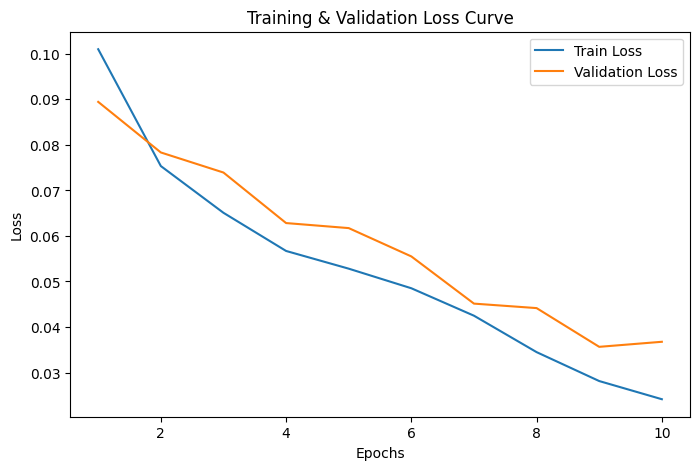

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Create train and test datasets
train_dataset, test_dataset = create_train_dataset(), create_test_dataset()

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (ensure DrawLocatorNet takes two inputs)
model = DrawLocatorNet().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Coordinate regression loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
train_loss = []
eval_loss = []

# Open log file
log_file = open("training_logs.txt", "w")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for batch_idx, (field_img, draw_img, labels) in enumerate(train_loader):
        # Move data to GPU if available
        field_img = field_img.to(device).float()
        draw_img = draw_img.to(device).float()
        labels = labels.to(device).float()  # Shape: (B,2)

        optimizer.zero_grad()
        outputs = model(field_img, draw_img)  # Model expects two inputs
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Log predictions and actual labels
        for i in range(len(labels)):
            log_file.write(f"Epoch: {epoch+1}, Batch: {batch_idx}, Train Prediction: {outputs[i].cpu().tolist()}, Actual: {labels[i].cpu().tolist()}\n")

    epoch_train_loss = running_loss / len(train_loader)
    train_loss.append(epoch_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}")

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (field_img, draw_img, labels) in enumerate(val_loader):
            field_img = field_img.to(device).float()
            draw_img = draw_img.to(device).float()
            labels = labels.to(device).float()

            outputs = model(field_img, draw_img)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Log validation predictions and actual labels
            for i in range(len(labels)):
                log_file.write(f"Epoch: {epoch+1}, Batch: {batch_idx}, Val Prediction: {outputs[i].cpu().tolist()}, Actual: {labels[i].cpu().tolist()}\n")

    epoch_val_loss = running_val_loss / len(val_loader)
    eval_loss.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {epoch_val_loss:.4f}")

    # Flush log file to ensure data is written
    log_file.flush()

# Close log file
log_file.close()

# Save the trained model
torch.save(model.state_dict(), "draw_locator_net.pth")

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_loss, label="Train Loss")
plt.plot(range(1, num_epochs+1), eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.show()


In [5]:
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch
import pandas as pd

def predict_draw_location(model, field_img_path, draw_img_path, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Run inference on a given field image and draw image to predict the draw's location.

    Args:
        model: Trained DrawLocatorNet model.
        field_img_path (str): Path to the field image (210x210).
        draw_img_path (str): Path to the draw image (50x50).
        device (str): Device to run inference on ("cuda" or "cpu").

    Returns:
        (float, float): Predicted (x, y) coordinates in the field image (normalized 0-1 range).
    """

    # Ensure the model is in evaluation mode
    model.eval()
    model.to(device)

    # Define transforms (assuming normalization was applied during training)
    transform = transforms.Compose([
        transforms.ToTensor(),   # Convert to tensor (C, H, W) and scale to [0,1]
    ])

    # Load and preprocess the images
    field_img = Image.open(field_img_path).convert('RGB').resize((210, 210))
    draw_img = Image.open(draw_img_path).convert('RGB').resize((50, 50))

    field_img = transform(field_img).unsqueeze(0).to(device)  # Shape: (1, 3, 210, 210)
    draw_img = transform(draw_img).unsqueeze(0).to(device)    # Shape: (1, 3, 50, 50)

    # Run inference
    with torch.no_grad():
        pred_coords = model(field_img, draw_img).cpu().numpy()[0]  # Shape: (2,)

    # Extract and return the (x, y) coordinates
    pred_x, pred_y = pred_coords*210
    print(f"Predicted Coordinates (Normalized): x={pred_x:.4f}, y={pred_y:.4f}")
    x = int(pred_x)
    y = int(pred_y)
    image_drawn = cv2.imread(field_img_path)
    # image_drawn = image_resized.copy()
    cv2.circle(image_drawn, (x, y), radius=5, color=(0, 0, 255), thickness=-1)  # Red circle

    # Display the image with the drawn points
    cv2.imshow("img",image_drawn)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return pred_x, pred_y

def draw_labels_on_image(image_path, labels_file):
    """
    Loads an image from image_path, retrieves ground truth (x1, y1, x2, y2) from labels.txt,
    and displays the image with red circles at those coordinates.

    Args:
        image_path (str): Path to the image.
        labels_file (str): Path to the labels file (CSV or TXT with x1, y1, x2, y2).
    """
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to load image: {image_path}")
        return

    # Resize the image to (width=340, height=410) to match the model's expected size
    image_resized = image #cv2.resize(image, (340, 410))

    # Read labels from the file
    labels_df = pd.read_csv(labels_file)  # Ensure labels.txt is formatted correctly
    image_name = image_path.split('/')[-1]  # Extract filename from path

    # Find the row corresponding to the image name (assuming there is an 'id' or filename column)
    if 'img_name' in labels_df.columns:
        row = labels_df[labels_df['img_name'] == image_name]
    else:
        row = labels_df.iloc[0]  # If there's no ID column, just use the first row (for testing)

    if row.empty:
        print(f"No labels found for {image_name}")
        return

    # Extract ground truth coordinates
    x1, y1, x2, y2 = row[['x1', 'y1', 'x2', 'y2']].to_numpy().flatten()
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    print(f"Ground truth coordinates: x1={x1}, y1={y1}, x2={x2}, y2={y2}")

    # Draw red circles at the ground truth coordinates
    image_drawn = image_resized.copy()
    cv2.circle(image_drawn, (x1, y1), radius=5, color=(0, 255, 0), thickness=-1)  # Green circle
    cv2.circle(image_drawn, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)  # Red circle

    # Display the image with the drawn points
    cv2.imshow("img",image_drawn)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Load the trained model
model = DrawLocatorNet()
model.load_state_dict(torch.load("draw_locator_net.pth", map_location="cuda" if torch.cuda.is_available() else "cpu"))

def run(captcha_num):
    print("Premier perso")
    field_path = f"truncated_captchas/captcha_{captcha_num}.png"
    draw_path = f"normalized_premier_perso/captcha_{captcha_num}.png"
    predict_draw_location(model, field_path, draw_path)
    draw_labels_on_image(field_path,labels_file="truncated_labels.csv")

    print("Second perso")
    field_path = f"truncated_captchas/captcha_{captcha_num}.png"
    draw_path = f"normalized_second_perso/captcha_{captcha_num}.png"
    predict_draw_location(model, field_path, draw_path)
    draw_labels_on_image(field_path,labels_file="truncated_labels.csv")

run(88)

Premier perso


FileNotFoundError: [Errno 2] No such file or directory: 'truncated_captchas/captcha_88.png'